In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#**Analyzers**

In [ ]:
from abc import ABC, abstractmethod

class Analyzer(ABC):
  def __init__(self, model: nn.Module):
    self.model = model.eval()

  @abstractmethod
  def analyze(self, input_tensor):
    pass

class GradCAMAnalyzer(Analyzer):
    def __init__(self, model, target_layer):
        super().__init__(model)
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def analyze(self, input_tensor):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        output = self.model(input_tensor)
        target_class = output.argmax(dim=1)
        self.model.zero_grad()
        output[0, target_class[0]].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam / cam.max()
        return cam

class GradientAnalyzer(Analyzer):
    def analyze(self, input_tensor):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        output = self.model(input_tensor)
        target_class = output.argmax(dim=1)
        grads = torch.zeros_like(input_tensor)
        for i, idx in enumerate(target_class):
            self.model.zero_grad()
            output[i, idx].backward(retain_graph=True)
            grads[i] = input_tensor.grad.data[i]
        return grads

class IntegratedGradientsAnalyzer(Analyzer):
    def __init__(self, model, steps=50):
        super().__init__(model)
        self.steps = steps

    def analyze(self, input_tensor):
        input_tensor = input_tensor.to(self.device)
        scaled_input = (input_tensor * alpha).detach().requires_grad_()
        grads = torch.zeros_like(input_tensor)
        for scaled_input in scaled_inputs:
            scaled_input.requires_grad = True
            output = self.model(scaled_input)
            target_class = output.argmax(dim=1)
            for i, idx in enumerate(target_class):
                self.model.zero_grad()
                output[i, idx].backward(retain_graph=True)
                grads[i] += scaled_input.grad.data[i] if scaled_input.grad is not None else 0
        return (input_tensor - baseline) * (grads / self.steps)

class LRPZRuleAnalyzer(Analyzer):
    def analyze(self, input_tensor):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        output = self.model(input_tensor)
        target_class = output.argmax(dim=1)
        grads = torch.zeros_like(input_tensor)
        for i, idx in enumerate(target_class):
            self.model.zero_grad()
            output[i, idx].backward(retain_graph=True)
            grads[i] = input_tensor.grad[i] * input_tensor[i]
        return grads

class LRPEpsilonRuleAnalyzer(Analyzer):
    def __init__(self, model, epsilon=1e-6):
        super().__init__(model)
        self.epsilon = epsilon

    def analyze(self, input_tensor):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        output = self.model(input_tensor)
        target_class = output.argmax(dim=1)
        grads = torch.zeros_like(input_tensor)
        for i, idx in enumerate(target_class):
            self.model.zero_grad()
            output[i, idx].backward(retain_graph=True)
            z = input_tensor.grad[i] * input_tensor[i]
            grads[i] = z / (z.abs() + self.epsilon)
        return grads

class LRPAlphaBetaAnalyzer(Analyzer):
    def __init__(self, model, alpha=1.0, beta=0.0):
        super().__init__(model)
        self.alpha = alpha
        self.beta = beta

    def analyze(self, input_tensor):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        output = self.model(input_tensor)
        target_class = output.argmax(dim=1)
        grads = torch.zeros_like(input_tensor)
        for i, idx in enumerate(target_class):
            self.model.zero_grad()
            output[i, idx].backward(retain_graph=True)
            g = input_tensor.grad[i]
            grads[i] = self.alpha * torch.clamp(g, min=0) * input_tensor[i] + \
                       self.beta * torch.clamp(g, max=0) * input_tensor[i]
        return grads

class NoiseTunnelAnalyzer(Analyzer):
    def __init__(self, model, base_analyzer, samples=10, noise_level=0.1):
        super().__init__(model)
        self.base_analyzer = base_analyzer
        self.samples = samples
        self.noise_level = noise_level

    def analyze(self, input_tensor):
        accumulated = torch.zeros_like(input_tensor)
        for _ in range(self.samples):
            noise = torch.randn_like(input_tensor) * self.noise_level
            noisy_input = input_tensor + noise
            attribution = self.base_analyzer.analyze(noisy_input)
            accumulated += attribution
        return accumulated / self.samples

class SmoothGradAnalyzer(Analyzer):
    def __init__(self, model, samples=25, noise_level=0.1):
        super().__init__(model)
        self.samples = samples
        self.noise_level = noise_level

    def analyze(self, input_tensor):
        grads = torch.zeros_like(input_tensor)
        for _ in range(self.samples):
            noise = torch.randn_like(input_tensor) * self.noise_level
            noisy_input = (input_tensor + noise).clone().detach().requires_grad_(True)
            output = self.model(noisy_input)
            target_class = output.argmax(dim=1)
            for i, idx in enumerate(target_class):
                self.model.zero_grad()
                output[i, idx].backward(retain_graph=True)
                grads[i] += noisy_input.grad.data[i] if noisy_input.grad is not None else 0
        return grads / self.samples

#**Learn**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([transforms.ToTensor()])
train_data = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(1):  # Use mais épocas se desejar
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), "simple_cifar10_model.pth")
print("Modelo salvo como 'simple_cifar10_model.pth'")

100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


Modelo salvo como 'simple_cifar10_model.pth'


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

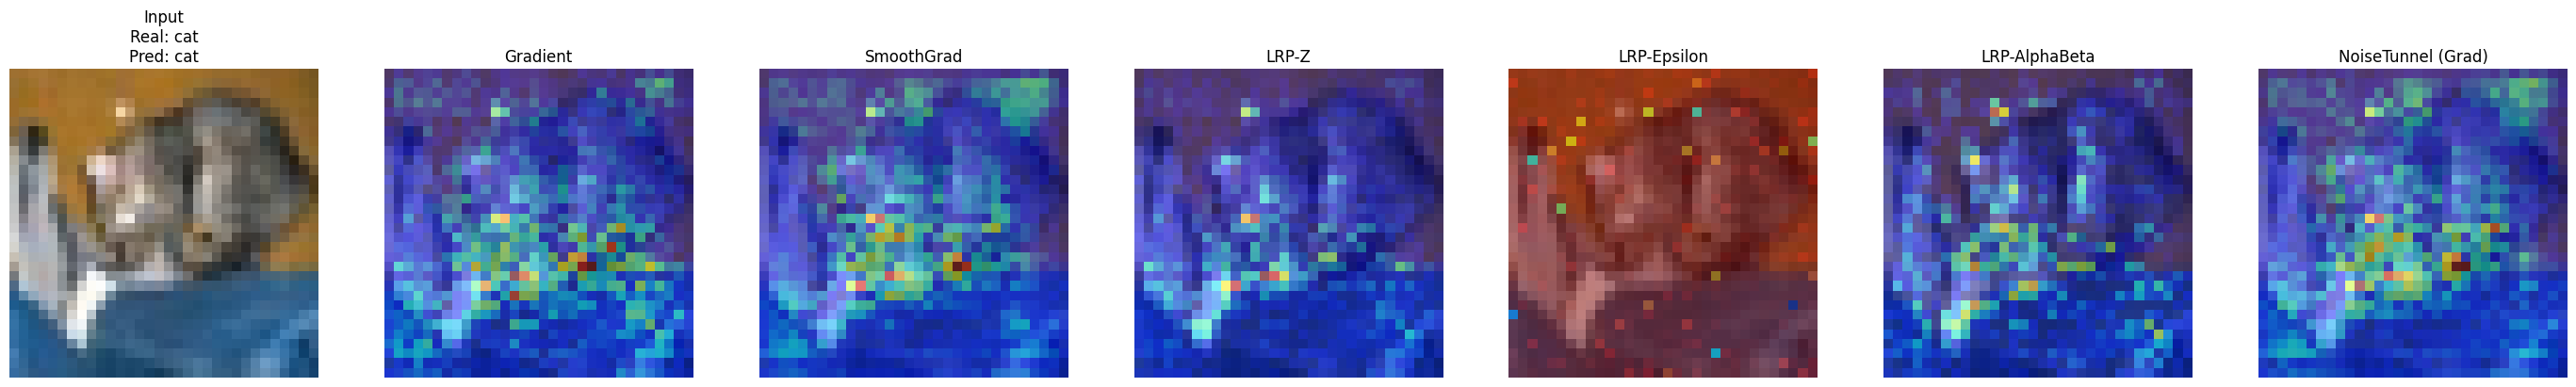

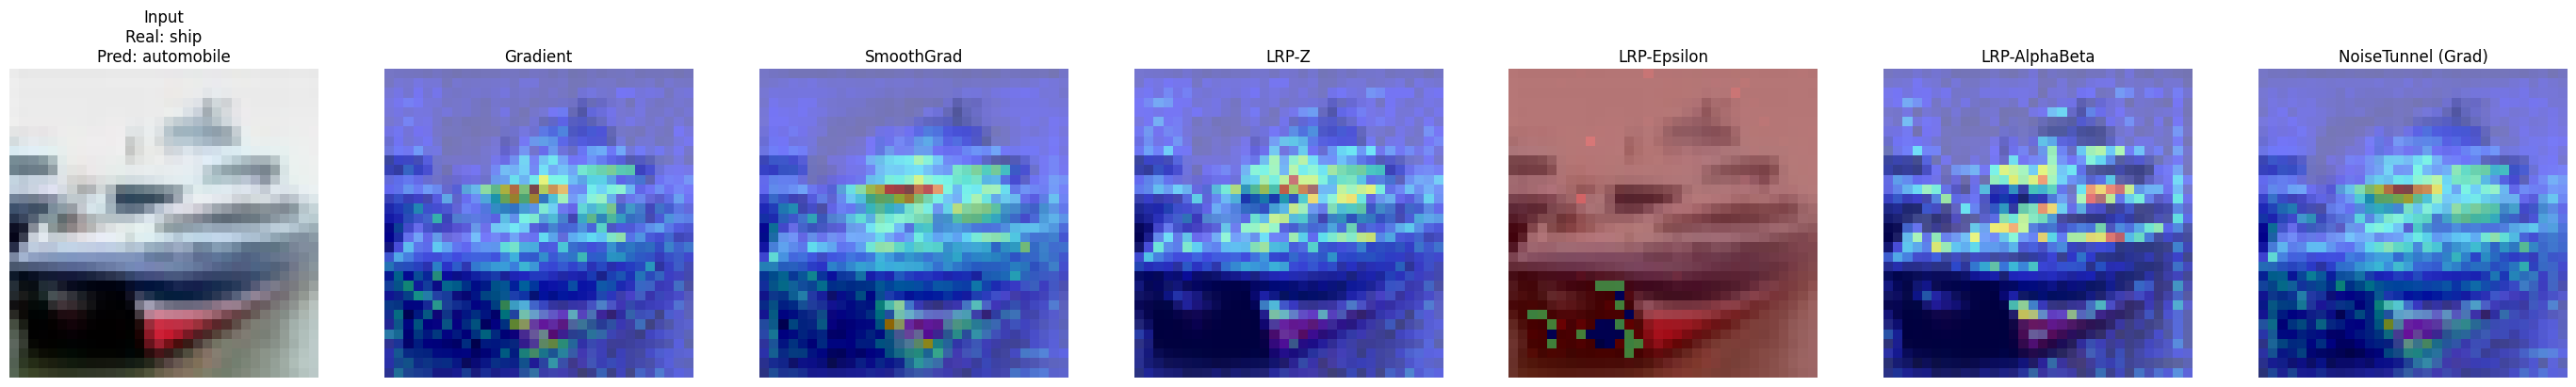

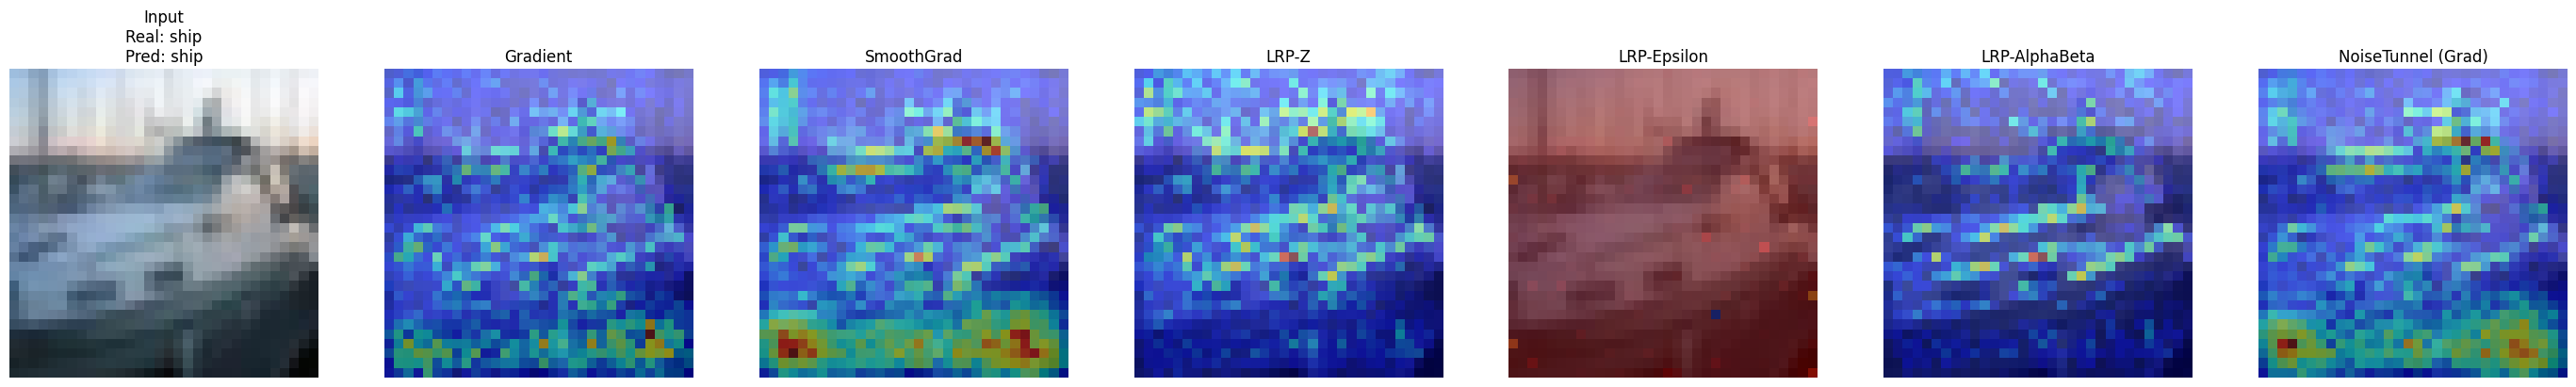

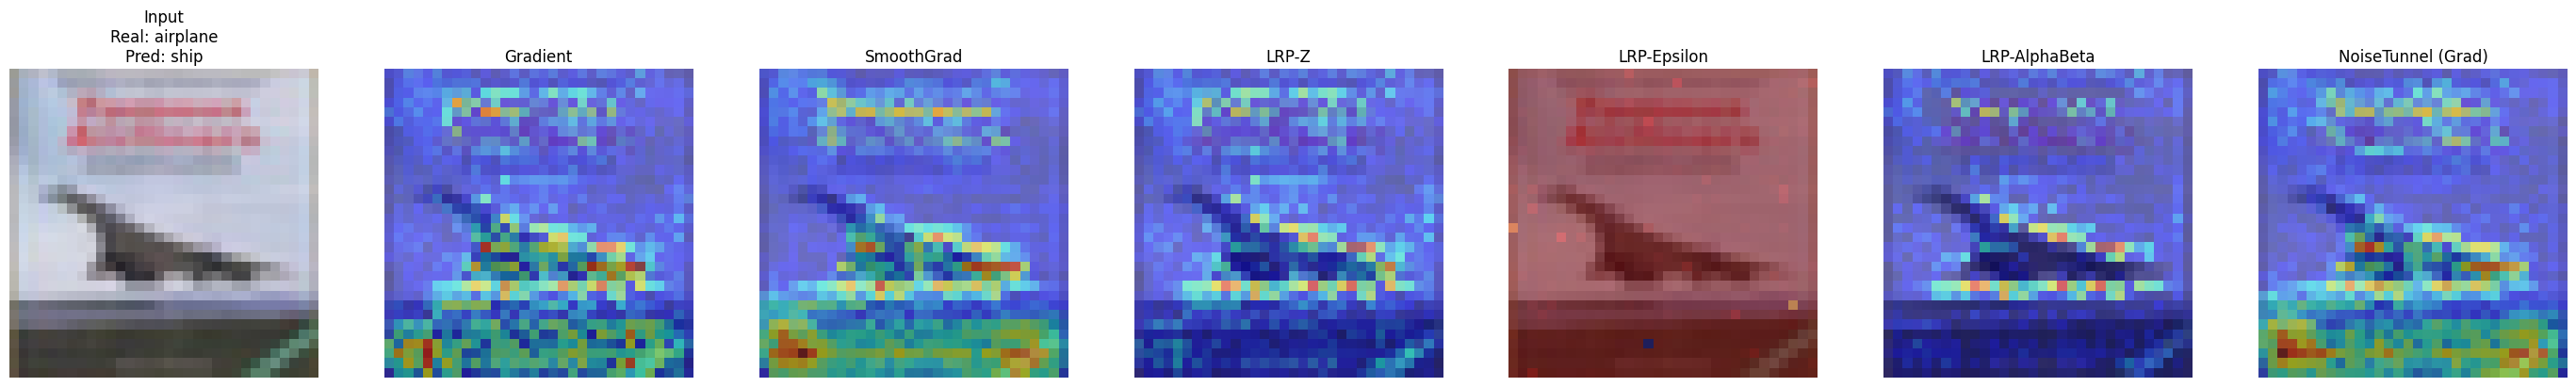

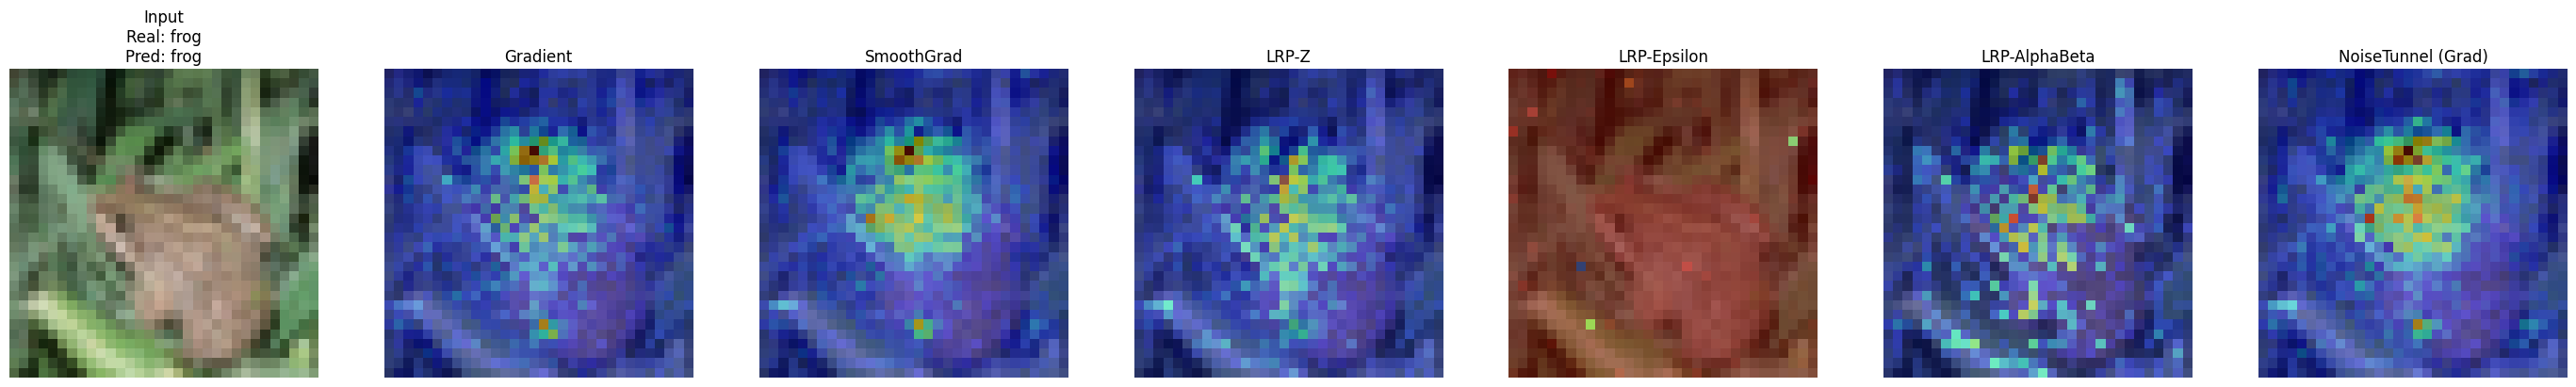

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
classes = testset.classes

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_cifar10_model.pth", map_location=device))
model.eval()

def plot_side_by_side(img_tensor, attributions, titles, label, prediction):
    num_methods = len(attributions)
    fig, axes = plt.subplots(1, num_methods + 1, figsize=(4 * (num_methods + 1), 4))

    img = img_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    img = np.clip(img, 0, 1)
    axes[0].imshow(img)
    axes[0].set_title(f"Input\nReal: {label}\nPred: {prediction}")
    axes[0].axis('off')

    for i in range(num_methods):
        attr = attributions[i].squeeze()
        if attr.ndim == 3:
            attr = attr.permute(1, 2, 0).detach().cpu().numpy()
            attr = np.abs(attr).mean(axis=2)
        elif attr.ndim == 2:
            attr = attr.detach().cpu().numpy()
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        axes[i + 1].imshow(img)
        axes[i + 1].imshow(attr, cmap='jet', alpha=0.5)
        axes[i + 1].set_title(titles[i])
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

analyzers = [
    ("Gradient", GradientAnalyzer(model)),
    ("SmoothGrad", SmoothGradAnalyzer(model)),
    ("LRP-Z", LRPZRuleAnalyzer(model)),
    ("LRP-Epsilon", LRPEpsilonRuleAnalyzer(model)),
    ("LRP-AlphaBeta", LRPAlphaBetaAnalyzer(model)),
    ("NoiseTunnel (Grad)", NoiseTunnelAnalyzer(model, GradientAnalyzer(model))),
]

for i, (inputs, labels) in enumerate(testloader):
    inputs = inputs.to(device)
    inputs.requires_grad = True

    outputs = model(inputs)
    pred = torch.argmax(outputs, dim=1)
    real_label = classes[labels.item()]
    pred_label = classes[pred.item()]

    attributions = []
    titles = []

    for name, analyzer in analyzers:
        attr = analyzer.analyze(inputs)
        attributions.append(attr)
        titles.append(name)

    plot_side_by_side(inputs, attributions, titles, label=real_label, prediction=pred_label)

    if i == 4:
        break